In [1]:
import pickle
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from genova.utils.BasicClass import Ion, Residual_seq

In [ ]:
experiment_name = 'Cerebellum'
psm_head = pd.read_csv('/data/z37mao/genova_new/{}_PSMs.csv'.format(experiment_name),index_col = 'File ID')
psm_head = psm_head[np.logical_and(psm_head['Percolator PEP']<0.05,psm_head['XCorr']>1)]
psm_head = psm_head[psm_head['Annotated Sequence'].str.len()<=32]

In [ ]:
buffer=''
for i, (index, seq) in enumerate(psm_head['Annotated Sequence'].iteritems()):
    buffer+='>{}\n'.format(index)
    buffer+='{}\n'.format(seq.upper())

In [ ]:
def cleavage_find(product_moverz,candidate_moverz,moverz_threshold=0.02):
    return np.array([0 if low_bound==high_bound else 1 for low_bound, high_bound in zip(product_moverz.searchsorted(candidate_moverz-moverz_threshold),product_moverz.searchsorted(candidate_moverz+moverz_threshold))])

In [ ]:
a=[]
b=[]
miss_cleavage_num = []
with open('/data/z37mao/genova_new/{}.mgfs'.format(experiment_name),'rb') as f:
    for i, (seq, charge, pointer, data_len, pep, xcorr) in psm_head[['Annotated Sequence','Charge','MGFS_Datablock_Pointer','MGFS_Datablock_Length','Percolator PEP','XCorr']].iterrows():
        f.seek(pointer)
        seq = seq.replace('L','I')
        product_moverz = pickle.loads(f.read(data_len))['product_ions_moverz']
        seq_composition = Residual_seq.seqs2composition_list(seq)
        seqaamass = np.array([aa_composition.mass for aa_composition in seq_composition])
        a_ion = Ion.sequencemz2ion(seqaamass[:-1].cumsum(),'1a')
        b_ion = Ion.sequencemz2ion(seqaamass[:-1].cumsum(),'1b')
        y_ion = np.flip(Ion.sequencemz2ion(np.flip(seqaamass)[:-1].cumsum(),'1y'))
        y2_ion = np.flip(Ion.sequencemz2ion(np.flip(seqaamass)[:-1].cumsum(),'2y'))
        a_ion = a_ion[a_ion<250]
        y2_ion = y2_ion[y2_ion>400]
        seq_len = len(seq)
        #if seq_len>32: continue
        a_cleavage = np.pad(cleavage_find(product_moverz,a_ion),[0,seq_len-a_ion.size-1])
        b_cleavage = cleavage_find(product_moverz,b_ion)
        y_cleavage = cleavage_find(product_moverz,y_ion)
        if charge>2:
            y2_cleavage = np.pad(cleavage_find(product_moverz,y2_ion),[seq_len-y2_ion.size-1,0])
            cleavage_result = (a_cleavage+b_cleavage+y_cleavage+y2_cleavage)>0
        else:
            cleavage_result = (a_cleavage+b_cleavage+y_cleavage)>0
        noncleavate=np.argwhere(cleavage_result).reshape(-1)[1:]-np.argwhere(cleavage_result).reshape(-1)[:-1]
        a.append(len(seq))
        b.append(np.max(noncleavate))
        miss_cleavage_num.append(np.max(noncleavate)-1)
        #b.append((noncleavate>2).sum()/noncleavate.size)
        #break
        #miss_cleavage_num += list(np.argwhere(cleavage_result).reshape(-1)[1:]-np.argwhere(cleavage_result).reshape(-1)[:-1])
#miss_cleavage_num = np.array(miss_cleavage_num)-1·

In [2]:
psm_head = []
for psm_file_name in glob('/data/z37mao/genova_new/*_PSMs.csv'):
    #if psm_file_name.split('/')[-1][:-9]=='Plasma' or psm_file_name.split('/')[-1][:-9]=='PXD008844':
    #    continue
    psm_head_temp = pd.read_csv(psm_file_name)
    psm_head_temp['File ID'] = psm_file_name.split('/')[-1][:-9]+':'+psm_head_temp['File ID']
    psm_head.append(psm_head_temp)
psm_head = pd.concat(psm_head)
psm_head = psm_head[np.logical_and(psm_head['Percolator PEP']<0.05,psm_head['XCorr']>1)]
psm_head = psm_head[psm_head['Annotated Sequence'].str.len()<=32]
candidate_index = psm_head['File ID']

In [3]:
psm_head = []
for psm_file_name in glob('/home/z37mao/psm_index/*csv'):
    psm_head_temp = pd.read_csv(psm_file_name)
    #psm_head_temp['File ID'] = psm_file_name.split('/')[-1][:-9]+':'+psm_head_temp['File ID']
    psm_head.append(psm_head_temp)
psm_head = pd.concat(psm_head)
psm_head[['Experiment Name','Raw File ID','Spectrum ID']] = psm_head['Spec Index'].str.split(':',expand=True)
psm_head = psm_head.set_index('Spec Index')
psm_head = psm_head.loc[set(psm_head.index).intersection(set(candidate_index))]

In [23]:
#psm_insterested = psm_head[psm_head['Experiment Name']=='Cerebellum']
psm_insterested = psm_head
origin_len = len(psm_insterested)
#psm_insterested = psm_insterested[psm_insterested['Node Number']<=512]
#psm_insterested = psm_insterested[psm_insterested['Relation Num']<=5e5]
#psm_insterested = psm_insterested[psm_insterested['Edge Num']<=1.5e6]
filted_len = len(psm_insterested)
print(filted_len/origin_len)

"""a,_,_ = plt.hist(psm_insterested['Node Number'],bins=[i for i in range(1024)])
plt.title('Node Number')
plt.show()
b,_,_ = plt.hist(psm_insterested['Relation Num'],bins=[i for i in range(0,1000000,1000)])
plt.title('Relation Num')
plt.show()
c,_,_ = plt.hist(psm_insterested['Edge Num'],bins=[i for i in range(0,2000000,1000)])
plt.title('Edge Num')
plt.show()"""

1.0


"a,_,_ = plt.hist(psm_insterested['Node Number'],bins=[i for i in range(1024)])\nplt.title('Node Number')\nplt.show()\nb,_,_ = plt.hist(psm_insterested['Relation Num'],bins=[i for i in range(0,1000000,1000)])\nplt.title('Relation Num')\nplt.show()\nc,_,_ = plt.hist(psm_insterested['Edge Num'],bins=[i for i in range(0,2000000,1000)])\nplt.title('Edge Num')\nplt.show()"

Text(0, 0.5, 'Edge Num')

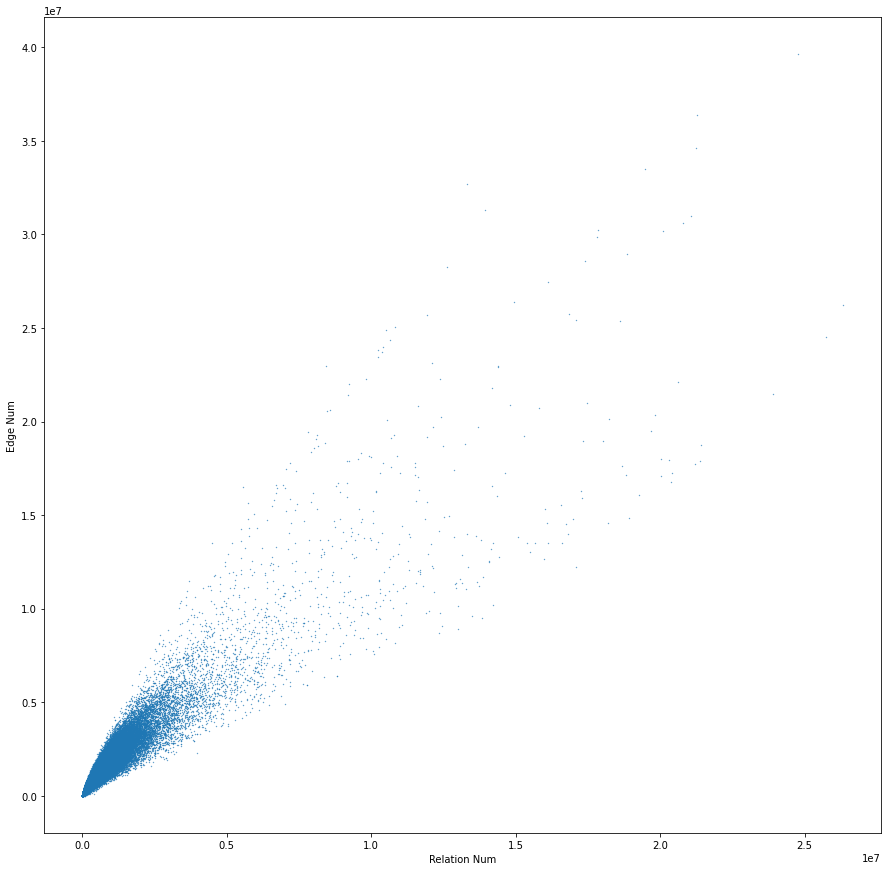

In [29]:
plt.figure(figsize=(15, 15))
plt.scatter(psm_insterested['Relation Num'],psm_insterested['Edge Num'],s=0.1)
plt.xlabel('Relation Num')
plt.ylabel('Edge Num')

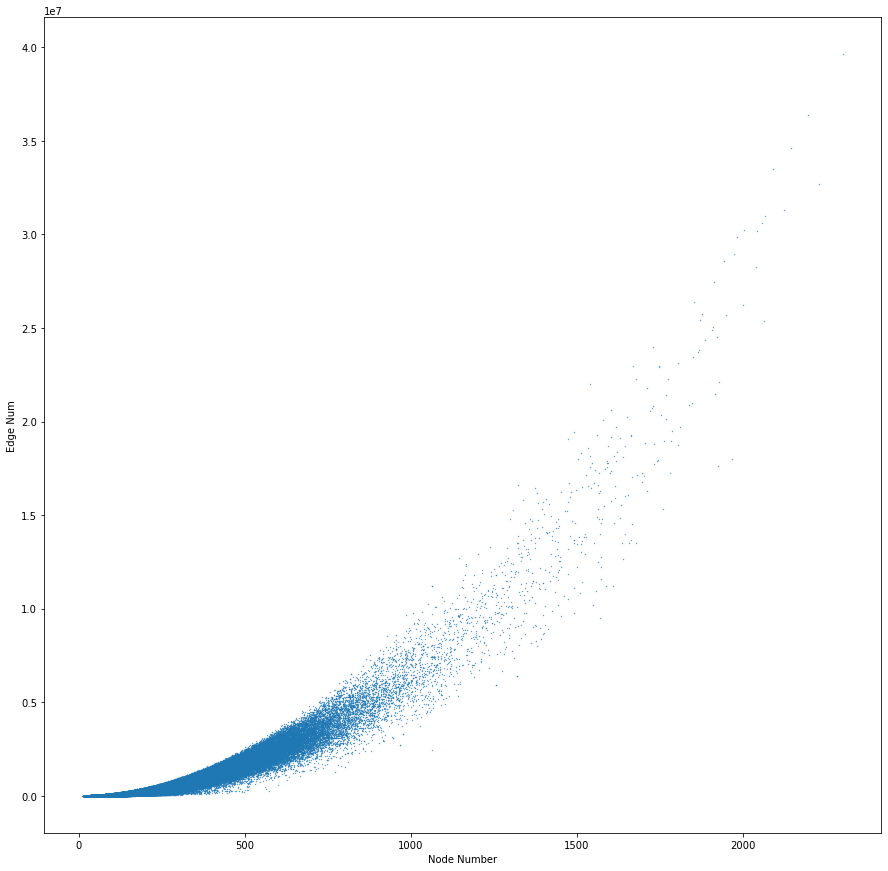

In [30]:
plt.figure(figsize=(15, 15))
plt.scatter(psm_insterested['Node Number'],psm_insterested['Edge Num'],s=0.1)
plt.xlabel('Node Number')
plt.ylabel('Edge Num')
plt.show()

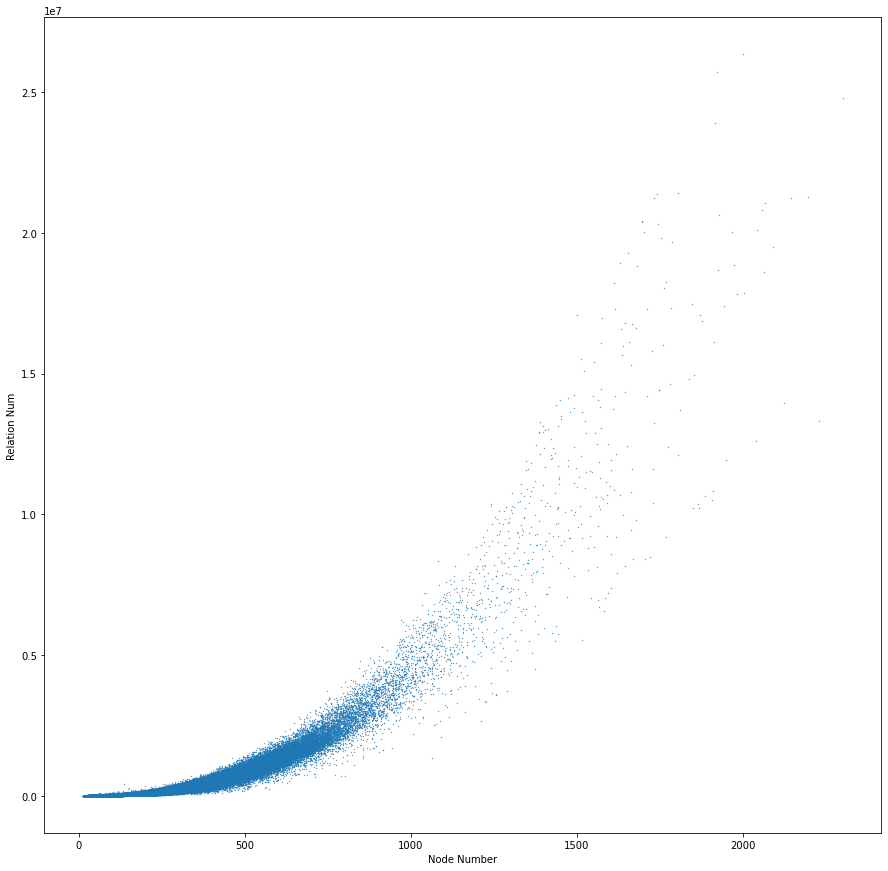

In [31]:
plt.figure(figsize=(15, 15))
plt.scatter(psm_insterested['Node Number'],psm_insterested['Relation Num'],s=0.1)
plt.xlabel('Node Number')
plt.ylabel('Relation Num')
plt.show()

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(psm_insterested['Node Number'],psm_insterested['Relation Num'],psm_insterested['Edge Num'],s=0.0005,c='red')
ax.set_xlabel('Node Number')
ax.set_ylabel('Relation Number')
ax.set_zlabel('Edge Number')

In [ ]:
pickle.dump(fig, open('FigureObject.fig.pickle', 'wb'))

In [ ]:
psm_insterested[['Node Number','Relation Num','Edge Num']]

In [ ]:
(psm_insterested['Node Number']>512).sum()/psm_insterested['Node Number'].size

In [ ]:
(psm_insterested['Relation Num']>5e5).sum()/psm_insterested['Relation Num'].size

In [ ]:
(psm_insterested['Edge Num']>1e6).sum()/psm_insterested['Edge Num'].size